In [45]:
import os
import gc
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from decimal import ROUND_HALF_UP, Decimal
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_colwidth', 3000)

## Things to add in my model

## to add attributes 
from sklearn.preprocessing import OneHotEncoder

## Create pipeline
- Select relevant 2000
- Combine frames
- Hot encoding
- Adjust prices (split/SplitReverse)
- Create features
- Standard Scaler
- Drop labels

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer


## create a function to replace 0 by NaN
def replace_0_2_NaN(data):
    data[data == 0] = np.nan
    return data


num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num0_pipeline.fit_transform(housing[['BuildingArea','Landsize']])



housing_num_tr = num_pipeline.fit_transform(housing_num)



cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])



from sklearn.compose import ColumnTransformer

num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']


full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)






**Data Pipeline**

In [6]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

**MLs Model**

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor

### Local

%%time
financials_df = pd.read_csv("train_files/financials.csv")
options_df = pd.read_csv("train_files/options.csv")
secondary_stock_prices_df = pd.read_csv("train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("train_files/stock_prices.csv")
trades_df = pd.read_csv("train_files/trades.csv")
stocks_df = pd.read_csv("stock_list.csv")

### Kaggle

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

**Datasets**

In [4]:
%%time 
#financials_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
#options_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
#secondary_stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
trades_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/trades.csv")
stocks_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")

CPU times: user 6.54 s, sys: 419 ms, total: 6.96 s
Wall time: 8.56 s


**Suplemental files**

In [19]:
financials_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv")
options_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/options_spec.csv")
stock_prices_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_price_spec.csv")
trades_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
stocks_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_list_spec.csv")

## 0. Utils

In [14]:
def plot_candle_with_target(df_prices, stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [15]:
def plot_candle_with_target_adjusted(df_prices, stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['AdjustedOpen'].values, 
        'high': df_['AdjustedHigh'].values, 
        'low': df_['AdjustedLow'].values, 
        'close': df_['AdjustedClose'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

### Evaluation function

In [16]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

**Adjust Split-Reverse/split price**

In [17]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        )) 

        # generate AdjustedOpen
        df.loc[:, "AdjustedOpen"] = (
            df["CumulativeAdjustmentFactor"] * df["Open"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate AdjustedHigh
        df.loc[:, "AdjustedHigh"] = (
            df["CumulativeAdjustmentFactor"] * df["High"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate Low
        df.loc[:, "AdjustedLow"] = (
            df["CumulativeAdjustmentFactor"] * df["Low"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
       
        #df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedOpen"] = df.loc[:, "AdjustedOpen"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedHigh"] = df.loc[:, "AdjustedHigh"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedLow"] = df.loc[:, "AdjustedLow"].interpolate(method='linear',limit_direction='backward')

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    price.drop(columns=['Open', 'High','Low','Close','AdjustmentFactor'],inplace =True)
    #price.set_index("Date", inplace=True)
    return price

## 1. Exploratory Data Analysis

### Stock prices
stock_prices.csv

File Description
The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in stock_price_spec.csv:

    RowId: Unique ID of price records, the combination of Date and SecuritiesCode.
    Date: Trade date.
    SecuritiesCode: Local securities code.
    Open: First traded price on a day.
    High: Highest traded price on a day.
    Low: Lowest traded price on a day.
    Close: Last traded price on a day.
    Volume: Number of traded stocks on a day.
    AdjustmentFactor: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
    ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
    SupervisionFlag: Flag of securities under supervision and securities to be delisted, for more information, please see here.
    Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

In [21]:
stock_prices_info

,Column,Sample value,Type,Addendum,Remarks
0,RowId,20170104_1301,string,NaN,Unique ID of price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date
2,SecuritiesCode,1301,Int64,NaN,Local securities code
3,Open,2734,float,NaN,first traded price on a day
4,High,2755,float,NaN,highest traded price on a day
5,Low,2730,float,NaN,lowest traded price on a day
6,Close,2742,float,NaN,last traded price on a day
7,Volume,31400,Int64,NaN,number of traded stocks on a day
8,AdjustmentFactor,1,float,NaN,to calculate theoretical price/volume when spl...
9,SupervisionFlag,FALSE,boolean,NaN,Flag of Securities Under Supervision & Securit...


In [22]:
display(stock_prices_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [23]:
stock_prices_df.shape

(2332531, 12)

In [24]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [25]:
stock_prices_df.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2.332531e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.332531e+06,2.332531e+06,18865.000000,2.332293e+06
mean,5.894835e+03,2.594511e+03,2.626540e+03,2.561227e+03,2.594023e+03,6.919366e+05,1.000508e+00,22.017730,4.450962e-04
std,2.404161e+03,3.577192e+03,3.619363e+03,3.533494e+03,3.576538e+03,3.911256e+06,6.773040e-02,29.882453,2.339879e-02
min,1.301000e+03,1.400000e+01,1.500000e+01,1.300000e+01,1.400000e+01,0.000000e+00,1.000000e-01,0.000000,-5.785414e-01
25%,3.891000e+03,1.022000e+03,1.035000e+03,1.009000e+03,1.022000e+03,3.030000e+04,1.000000e+00,5.000000,-1.049869e-02
50%,6.238000e+03,1.812000e+03,1.834000e+03,1.790000e+03,1.811000e+03,1.071000e+05,1.000000e+00,15.000000,0.000000e+00
75%,7.965000e+03,3.030000e+03,3.070000e+03,2.995000e+03,3.030000e+03,4.021000e+05,1.000000e+00,30.000000,1.053159e-02
max,9.997000e+03,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,6.436540e+08,2.000000e+01,1070.000000,1.119512e+00


**Missing values**

In [26]:
display(pd.isna(stock_prices_df).sum()/len(stock_prices_df)*100)

RowId                0.000000
Date                 0.000000
SecuritiesCode       0.000000
Open                 0.326169
High                 0.326169
Low                  0.326169
Close                0.326169
Volume               0.000000
AdjustmentFactor     0.000000
ExpectedDividend    99.191222
SupervisionFlag      0.000000
Target               0.010204
dtype: float64

In [27]:
missing_high = stock_prices_df[stock_prices_df["High"].isna()]

In [28]:
display(missing_high.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
1753,20170104_9539,2017-01-04,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.004149
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2511,20170105_4621,2017-01-05,4621,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [29]:
display(missing_high.shape[0])

7608

In [30]:
missing_high["Date"].nunique()

1175

In [31]:
missing_high["Date"].value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In [32]:
plot_missing_high_df = missing_high["Date"].value_counts().to_frame().reset_index()
plot_missing_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_high_df.head()

,Date,Count
0,2020-10-01,1988
1,2017-03-16,15
2,2019-10-09,14
3,2019-04-04,14
4,2021-10-29,13


2020-10-01 is the day with the most amount of missing data

In [34]:
plot_missing_high_df["Date"] = pd.to_datetime(plot_missing_high_df["Date"])
plot_missing_high_df.sort_values(by="Date",inplace=True)

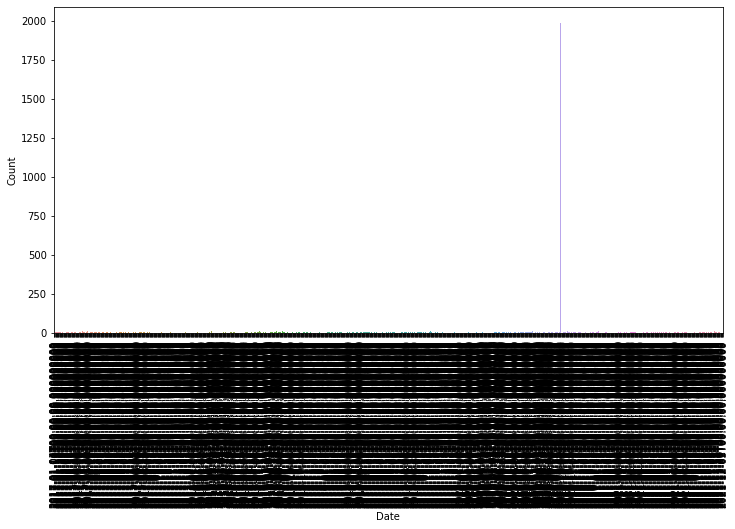

In [35]:

ax = plt.subplots(figsize = (12,6))    
ax= sns.barplot(x = "Date", y = "Count", data = plot_missing_high_df)
ax.tick_params(axis='x', rotation=90)


In [36]:
missing_Target = stock_prices_df[stock_prices_df["Target"].isna()]

In [37]:
display(missing_Target.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
5996,20170110_3540,2017-01-10,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
7861,20170111_3540,2017-01-11,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [38]:
display(missing_Target.shape[0])

238

In [39]:
missing_Target["Date"].nunique()

238

In [40]:
missing_Target["Date"].value_counts()

2017-01-04    1
2017-08-30    1
2017-08-14    1
2017-08-15    1
2017-08-16    1
             ..
2017-05-08    1
2017-05-09    1
2017-05-10    1
2017-05-11    1
2020-10-02    1
Name: Date, Length: 238, dtype: int64

In [41]:
plot_missing_target_df = missing_Target["Date"].value_counts().to_frame().reset_index()
plot_missing_target_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_target_df

,Date,Count
0,2017-01-04,1
1,2017-08-30,1
2,2017-08-14,1
3,2017-08-15,1
4,2017-08-16,1
...,...,...
233,2017-05-08,1
234,2017-05-09,1
235,2017-05-10,1
236,2017-05-11,1


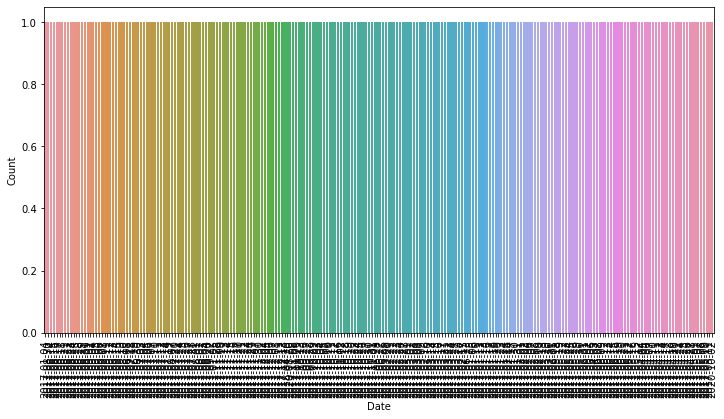

In [42]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Date", y = "Count", data = plot_missing_target_df, ax=ax)
ax.tick_params(axis='x', rotation=90)

### Stocks

stock_list.csv


SecuritiesCode: Local securities code.
    EffectiveDate: The effective date. (Need clarification.)
    Name: Name of security.
    Section/Products: Section/Product.

    NewMarketSegment: New market segment effective from 2022-04-04 (as of 15:30 JST on Mar 11 2022). For more information, please see Overview of Market Restructuring.
    33SectorCode: 33 sector code.
    33SectorName: 33 sector name.
    17SectorCode: 17 sector code.
    17SectorName: 17 sector name.
　
 For more information about sector code and name, please see TOPIX Sector Indices / TOPIX-17 Series

    NewIndexSeriesSizeCode: TOPIX New Index Series code.
    NewIndexSeriesSize: TOPIX New Index Series name.
For more information about TOPIX New Index Series code and name, please see TOPIX New Index Series / Size-based TOPIX.

    TradeDate: Trade date to calculate MarketCapitalization.
    Close: Close price to calculate MarketCapitalization.
    IssuedShares: Issued shares.
    MarketCapitalization: Market capitalization on December 3, 2021.
    Universe0: A flag of prediction target universe (top 2000 stocks by market capitalization).

In [44]:
display(stocks_info)

,Column,Sample value,Type,Addendum,Remarks
0,SecuritiesCode,1301,Int64,NaN,Local Securities Code
1,EffectiveDate,20211230,date,NaN,the effective date
2,Name,"KYOKUYO CO.,LTD.",string,NaN,Name of security
3,Section/Products,First Section (Domestic),string,NaN,Section/Product
4,NewMarketSegment,Prime Market,string,NaN,New market segment effective from 2022-04-04 (...
5,33SectorCode,50,Int64,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
6,33SectorName,"Fishery, Agriculture and Forestry",string,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
7,17SectorCode,1,Int64,NaN,17 Sector Code\nref. https://www.jpx.co.jp/eng...
8,17SectorName,FOODS,string,NaN,17 Sector Name\nref. https://www.jpx.co.jp/eng...
9,NewIndexSeriesSizeCode,7,Int64,NaN,TOPIX New Index Series code\n\nref. https://ww...


In [ ]:
display(stocks_df.head(5))

In [ ]:
stocks_df.shape

In [ ]:
stocks_df.info()

In [ ]:
display(pd.isna(stocks_df).sum()/len(stocks_df)*100)

In [ ]:
stocks_missing_Date = stocks_df[stocks_df["TradeDate"].isna()]
stocks_missing_Date.head()

In [ ]:
stocks_missing_segment = stocks_df[stocks_df["NewMarketSegment"].isna()]
stocks_missing_segment.head()

In [ ]:
stocks_df["Universe0"].value_counts()

In [ ]:
stocks_df["33SectorName"].value_counts()

In [ ]:
sector = stocks_df["33SectorName"].value_counts().to_frame()
sector.reset_index(inplace=True)
sector["percentage"] = sector["33SectorName"]/sector["33SectorName"].sum()*100
sector.head(5)

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(sector["percentage"], labels = sector["index"])
plt.show()

In [ ]:
stocks_df["Section/Products"].value_counts()

In [ ]:
section = stocks_df["Section/Products"].value_counts().to_frame()
section.reset_index(inplace=True)
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100
section

In [ ]:
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section["percentage"], labels = section["index"])
plt.show()

## Selecting the top 2000 Stocks (Universe0 Flag = True)

In [ ]:
stocks2000_df = stocks_df[stocks_df["Universe0"]]
stocks2000_df

In [ ]:
stocks2000_df.info()

In [ ]:
stocks2000_df["33SectorName"].value_counts()

In [ ]:
sector2000 = stocks2000_df["33SectorName"].value_counts().to_frame()
sector2000.reset_index(inplace=True)
sector2000["percentage"] = sector2000["33SectorName"]/sector2000["33SectorName"].sum()*100
sector2000.head(5)

In [ ]:
plt.rcParams["figure.figsize"] = (40,10)
plt.pie(sector2000["percentage"], labels = sector2000["index"])
plt.show()

In [ ]:
section2000 = stocks2000_df["Section/Products"].value_counts().to_frame()
section2000.reset_index(inplace=True)
section2000["percentage"] = section2000["Section/Products"]/section2000["Section/Products"].sum()*100
section2000

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section2000["percentage"], labels = section2000["index"])
plt.show()

## Merging Stock metadate with stock price

In [ ]:
col = ["SecuritiesCode","Name","Section/Products","NewMarketSegment","33SectorCode","33SectorName","17SectorCode","17SectorName","NewIndexSeriesSizeCode","NewIndexSeriesSize","IssuedShares","MarketCapitalization"]
df_prices = pd.merge(stock_prices_df, stocks2000_df[col], on='SecuritiesCode')
df_prices.head()

**Free memory**

In [ ]:
del stock_prices_df
del stocks2000_df

gc.collect()

**Calculating Target variable statistics**

In [ ]:
mean_securities_df = df_prices.groupby(["SecuritiesCode"])["Target"].mean()
total_mean_securities = mean_securities_df.mean()
total_mean_securities

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_securities_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_securities, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Securities\n"
             f"Min {round(mean_securities_df.min(), 4)} | "
             f"Max {round(mean_securities_df.max(), 4)} | "
             f"Skewness {round(mean_securities_df.skew(), 2)} | "
             f"Kurtosis {round(mean_securities_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

In [ ]:
mean_date_df = df_prices.groupby(["Date"])["Target"].mean()
total_mean_date = mean_date_df.mean()
total_mean_date

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_date_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_date, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Date\n"
             f"Min {round(mean_date_df.min(), 4)} | "
             f"Max {round(mean_date_df.max(), 4)} | "
             f"Skewness {round(mean_date_df.skew(), 2)} | "
             f"Kurtosis {round(mean_date_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

## Add correlation maps: between different securities, sectors

In [ ]:
### ADD CORRELATION MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP

### Target vs Sector33

In [ ]:
target_sector = df_prices.groupby(["33SectorName"])["Target"].mean()
target_sector.sort_values(inplace=True, ascending=False)


In [ ]:
target_sector = target_sector.to_frame()
target_sector.reset_index(inplace= True)

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "33SectorName", y = "Target", data = target_sector, ax=ax)
ax.set_title("Target Mean of Sectors")
ax.tick_params(axis='x', rotation=90)

### Target vs Section

In [ ]:
target_section = df_prices.groupby(["Section/Products"])["Target"].mean()
target_section.sort_values(inplace=True, ascending=False)


In [ ]:
target_section = target_section.to_frame()
target_section.reset_index(inplace= True)

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Section/Products", y = "Target", data = target_section, ax=ax)
ax.set_title("Target Mean of Sections")
ax.tick_params(axis='x', rotation=90)

### Secondary stock prices

Securities with low liquidity (few opportunities to trade)

In [ ]:
display(secondary_stock_prices_df.head(5))

In [ ]:
secondary_stock_prices_df.shape

In [ ]:
secondary_stock_prices_df.info()

In [ ]:
display(pd.isna(secondary_stock_prices_df).sum()/len(secondary_stock_prices_df)*100)

**Missing values**

In [ ]:
missing_secondary_high = secondary_stock_prices_df[secondary_stock_prices_df["High"].isna()]
display(missing_secondary_high.head(5))

In [ ]:
missing_secondary_high["Date"].nunique()

In [ ]:
plot_missing_secondary_high_df = missing_secondary_high["Date"].value_counts().to_frame().reset_index()
plot_missing_secondary_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_secondary_high_df.head()

As happened with the primary stock list 2020-10-01 is the day with the most amount of missing data


## Trades

Aggregated summary of trading volumes from the previous business week. Following is column information recorded in trades_spec.csv:

    Date: Data published date, usually Thursday on the following week.
    StartDate: The first trading date in this trading week.
    EndDate: The last trading date in this trading week.
    Section: Market division name.

In [ ]:
display(trades_df.head(5))

### Financials 

In [ ]:
financials_df.head()

In [ ]:
financials_df.shape

In [ ]:
financials_df.info()

In [ ]:
display(pd.isna(financials_df).sum()/len(financials_df)*100)

Super interesting for the stock price prediction but most of the data is missing...

### Options

**File Description**

Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly. Following is column information recorded in options_spec.csv:

    DateCode: Unique ID for option price records, the combintion of Date and OptionCode.
    Date: Trade date and time.
    OptionsCode: Local securities code. Detailed information is provided in Identification Code Specifications for Futures and Options Transactionssakimono20220208-e.pdf).
    WholeDayOpen: Opening price for whole trading day.
    WholeDayHigh: Highest price for whole trading day.
    WholeDayLow: Lowest price for whole trading day.
    WholeDayClose: Closing price for whole trading day.
    NightSessionOpen: Opening price for night session.
    NightSessionHigh: Highest price for night session.
    NightSessionLow: Lowest price for night session.
    NightSessionClose: Closing price for night session.
    DaySessionOpen: Opening price for day session.
    DaySessionHigh: Highest price for day session.
    DaySessionLow: Lowest price for day session.
    DaySessionClose: Closing price for day session.
    TradingVolume: Trading volume of the product/contract for the whole trading day.
    OpenInterest: Open interest of the product/contract for the whole trading day
    TradingValue: Trading value of the product/contract for the whole trading day
    ContractMonth: Cotract year-month of the product/contract.
    StrikePrice: Exercise price of product/contract.
    DaySessionVolume: Trading volume of the product/contract for day session.
    Putcall: 1 for put and 2 for call.
    LastTradingDay: Last trading day.
    SpecialQuotationDay: The day when the Special Quotation is calculated.
    SettlementPrice: Settlement price.
    TheoreticalPrice: The theoretical price at the end of a day session.
    BaseVolatility: The volatility at the time of calculating the settlement price.
    ImpliedVolatility: Implied volatility.
    InterestRate: Interest rate for calculation.
    DividendRate: Dividend yeild.
    Dividend: Devidend.

In [ ]:
options_df.head()

In [ ]:
options_df.shape

In [ ]:
options_df.info()

## 2. Cleaning data
- Input missing days
- Adjust price (Split- Reverse/split)
- Standarize values?


#### Generate Adjusted Close price
AdjustedClose using AdjustmentFactor value. This should reduce historical price gap caused by split/reverse-split.

In [ ]:
df_prices_adj = adjust_price(df_prices)
df_prices_adj.head(5)

In [ ]:
del df_prices
gc.collect()

In [ ]:
df_prices_adj["CumulativeAdjustmentFactor"].value_counts()

In [ ]:
df_prices_adj.info()

**Less missing values**

In [ ]:
display(pd.isna(df_prices_adj).sum()/len(df_prices_adj)*100)

**Now the OHTC chart shows continuity**

In [ ]:
plot_candle_with_target(df_prices, 9726, prime=True) 

In [ ]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 9726, prime=True) 

In [ ]:
plot_candle_with_target(df_prices, 4582, prime=True)

In [ ]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 4582, prime=True) 

In [ ]:
plot_candle_with_target(df_prices, 1805, prime=True)

In [ ]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 1805, prime=True) 

## 3. Feature Engineering
- Create basic statics
    1. Moving average
    2. Exponential moving average
    3. volatility
- Do not create Features since you are going to be using RNN
- Merge sentiment analysis data from Options
    1. https://www.boerse-stuttgart.de/de-de/tools/euwax-sentiment/
    2. https://www-mmds.sigmath.es.osaka-u.ac.jp/en/activity/vxj.php#:~:text=The%20Volatility%20Index%20Japan%20(VXJ,based%20on%20Nikkei225%20index%20options.
- Check correlation secondary stock market target vs Primary stock market target


**Correlogram to see if there is any autocorrelation**

In [ ]:
df_9726 =df_prices_adj[df_prices_adj["SecuritiesCode"]==9726]

In [ ]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedClose"])

In [ ]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedOpen"])

In [ ]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedHigh"])

In [ ]:
pd.plotting.autocorrelation_plot(df_9726["AdjustedLow"])

In [ ]:
pd.plotting.autocorrelation_plot(df_9726["Target"])

It certainly look like we are dealing with a random walk, as there are no indications of any autocorrelation for any lag.

Basically our LSTM found nothing of any real value to model and thus took the average value, along with a slight slope; we would have been just as well off with an extremely simplistic model of the form

C
l
o
s
e
t
∝
C
l
o
s
e
(
t
−
1
)

Price is correlated but price change shows no correlation. Therefore, the target variable itself will not give us much info about future stock movements... We need a good Feature engineering

### Feature Engineering

**From adjusted prices (individual)**
- Price changes
- Moving average
- Exponential moving average
- Volumen
- Volatility
- RSI: Low, Medium, High

**From adjusted prices (GroupBy sector?)**

**Price changes**


In [ ]:
period = [5,10,21,33]

In [ ]:
for i in period:
    df_9726[f"pct{i}"] = df_9726["AdjustedClose"].pct_change(i)
display(df_9726.head(5))

**Simple Moving Average (SMA)**

In [ ]:
period_avg = [10,20,50,60]

In [ ]:
for i in period_avg:
    df_9726[f"SMA_{i}"] = df_9726['AdjustedClose'].rolling(window=i).mean()

display(df_9726.tail(5))

**Exponential Moving Average (EMA)**

In [ ]:
for i in period_avg:
    df_9726[f"EMA_{i}"] = df_9726['AdjustedClose'].ewm(span=i,adjust=False).mean()

display(df_9726.tail(5))

Plotting the new features

In [ ]:
col_avg = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_20","EMA_60"]

In [ ]:
df_9726Avg = df_9726[col_avg]
df_9726Avg.head()

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
df_9726Avg.plot(title = "Avg analysis for Security Code")

In [ ]:
col_SMA = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60"]

In [ ]:
df_9726SMA = df_9726[col_SMA]
df_9726SMA.head()

In [ ]:
df_9726SMA.plot(title = "Avg analysis for Security Code")

In [ ]:
col_EMA = ["AdjustedClose","EMA_10","EMA_20","EMA_50","EMA_60"]

In [ ]:
df_9726EMA = df_9726[col_EMA]
df_9726EMA.head()

In [ ]:
df_9726EMA.plot(title = "Avg analysis for Security Code")

In [ ]:
def generate_feature(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime

    def generate_feature_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): Features for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate PriceChanges
        period = [5,10,21,33]
        for i in period:
            df[f"pct{i}"] = df["AdjustedClose"].pct_change(i)
            df.loc[:, f"pct{i}"] = df.loc[:, f"pct{i}"].interpolate(method='linear',limit_direction='backward')
            df.loc[:,f"Volatility_{i}"] = np.log(df["AdjustedClose"]).diff().rolling(i).std()
            df.loc[:, f"Volatility_{i}"] = df.loc[:, f"Volatility_{i}"].interpolate(method='linear',limit_direction='backward')

        period_avg = [10,20,50,60]
        for i in period_avg:
         
            # generate SMA
            df[f"SMA_{i}"] = df['AdjustedClose'].rolling(window=i).mean()
            df.loc[:, f"SMA_{i}"] = df.loc[:, f"SMA_{i}"].interpolate(method='linear',limit_direction='backward')
          
            # generate EMA
            df[f"EMA_{i}"] = df['AdjustedClose'].ewm(span=i,adjust=False).mean()
            df.loc[:, f"EMA_{i}"] = df.loc[:, f"EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # reverse order
        df = df.sort_values("Date")

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_feature_close).reset_index(drop=True)
    #price.set_index("Date", inplace=True)
    return price

In [ ]:
df_prices_feat = generate_feature(df_prices_adj)
df_prices_feat.head(5)

In [ ]:
del df_prices_adj
gc.collect()

**Feature engineering by Group**
- SectorCode33
- Section

In [ ]:
for i in period_avg:
    df_prices_feat[f"Sector_SMA_{i}"] = df_prices_feat.groupby('33SectorCode').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
    df_prices_feat.loc[:, f"Sector_SMA_{i}"] = df_prices_feat.loc[:, f"Sector_SMA_{i}"].interpolate(method='linear',limit_direction='backward')

In [ ]:
df_prices_feat.tail()

In [ ]:
col_Sector = ["AdjustedClose","Sector_SMA_10","Sector_SMA_20","Sector_SMA_50","Sector_SMA_90"]

In [ ]:
df_1301_feat = df_prices_feat[df_prices_feat["SecuritiesCode"]==1301]

In [ ]:
df_1301_feat = df_1301_feat[col_Sector]
df_1301_feat.head()

In [ ]:
df_1301_feat.plot(title = "Avg analysis for Security Code")

**It seems to be a correlation between the total sector trend and security trend**

In [ ]:
for i in period_avg:
    df_prices_feat[f"Sector_EMA_{i}"] = df_prices_feat.groupby('33SectorCode').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
    df_prices_feat.loc[:, f"Sector_EMA_{i}"] = df_prices_feat.loc[:, f"Sector_EMA_{i}"].interpolate(method='linear',limit_direction='backward')

In [ ]:
df_prices_feat.head(5)

In [ ]:
sec_array = df_prices_feat[df_prices_feat["33SectorCode"] == "50"]["SecuritiesCode"].unique()

In [ ]:
sec_array


In [ ]:
df_1301 = df_prices_feat[df_prices_feat["SecuritiesCode"] == 1301]
df_1301 = df_1301[col_Sector]
df_1301.head()

In [ ]:
df_1301.plot(title = "Avg analysis for Security Code")

In [ ]:
def generate_feature_group(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime

    def generate_feature_group_by(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): Features for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate SMA SectorCode
        period_avg = [10,20,50,90]
        for i in period_avg:
            df[f"Sector_SMA_{i}"] = df.groupby('33SectorCode').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"Sector_SMA_{i}"] = df.loc[:, f"Sector_SMA_{i}"].interpolate(method='linear',limit_direction='backward')
            
        # generate EMA SectorCode
        for i in period_avg:
            df[f"Sector_EMA_{i}"] = df.groupby('33SectorCode').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"Sector_EMA_{i}"] = df.loc[:, f"Sector_EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # generate SMA Section/Products
        period_avg = [10,20,50,90]
        for i in period_avg:
            df[f"SectionProduct_SMA_{i}"] = df.groupby('Section/Products').rolling(i)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"SectionProduct_SMA_{i}"] = df.loc[:, f"SectionProduct_SMA_{i}"].interpolate(method='linear',limit_direction='backward')
            
        # generate EMA Section/Products
        for i in period_avg:
            df[f"SectionProduct_EMA_{i}"] = df.groupby('Section/Products').ewm(span=i,adjust=False)['AdjustedClose'].mean().reset_index(drop=True)
            df.loc[:, f"SectionProduct_EMA_{i}"] = df.loc[:, f"SectionProduct_EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # reverse order
        df = df.sort_values("Date")
        return df

    # generate AdjustedClose
    #price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_feature_group_by).reset_index(drop=True)
    #price = price.apply(generate_feature_group_by).reset_index(drop=True)
    #price.set_index("Date", inplace=True)
    return price

import sys
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
df_prices_feat_group = generate_feature_group(df_prices_feat)
df_prices_feat_group

In [ ]:

display(pd.isna(df_prices_feat_group).sum()/len(df_prices_feat_group)*100)

### 3. Prediction Model

In [ ]:
X = df_prices_feat[["Date","SecuritiesCode","Target","Volume","AdjustedClose","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"]]
X=X.dropna().sort_values(['Date','SecuritiesCode'])


In [ ]:
y= X["Target"].to_numpy()
X=X.drop(["Target"],axis=1)

### Time based Crossvalidation

In [ ]:
params = {'n_estimators': 500,
          'num_leaves' : 100,
          'learning_rate': 0.1,
          'colsample_bytree': 0.9,
          'subsample': 0.8,
          'reg_alpha': 0.4,
          'metric': 'mae',
          'random_state': 21}

In [ ]:
ts_fold = TimeSeriesSplit(n_splits=10, gap=10000)

In [ ]:
feat_importance=pd.DataFrame()
sharpe_ratio=[]

In [ ]:
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    
    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))
    
    X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
    X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
    val_dates=X_valid.Date.unique()[1:-1]
    print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    gbm = LGBMRegressor(**params).fit(X_train, y_train, 
                                      eval_set=[(X_train, y_train), (X_val, y_val)],
                                      verbose=300, 
                                      eval_metric=['mae','mse'])
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    feat_importance.set_index(X_train.columns, inplace=True)
        
    rank=[]
    X_val_df=X_valid[X_valid.Date.isin(val_dates)]
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
        temp_df["pred"] = gbm.predict(temp_df)
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)

    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                  df_prices_feat[df_prices_feat.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=calc_spread_return_sharpe(df)
    sharpe_ratio.append(sharpe)
    print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))
    
    #del X_train, y_train,  X_val, y_val
    gc.collect()
    
print("\nAverage cross-validation Sharpe Ratio: {:.4f}, standard deviation = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))

In [ ]:
feat_importance['avg'] = feat_importance.mean(axis=1)
feat_importance = feat_importance.sort_values(by='avg',ascending=True)
pal=sns.color_palette("plasma_r", 29).as_hex()[2:]

fig=go.Figure()
for i in range(len(feat_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feat_importance['avg'][i], 
                       line_color=pal[::-1][i],opacity=0.7,line_width=4))
fig.add_trace(go.Scatter(x=feat_importance['avg'], y=feat_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(title='Overall Feature Importance', 
                  xaxis=dict(title='Average Importance',zeroline=False),
                  yaxis_showgrid=False, margin=dict(l=120,t=80),
                  height=700, width=800)
fig.show()

### 5.API Submission

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
cols=['Date','SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor']
stock_prices_df=stock_prices_df[stock_prices_df.Date>='2021-08-01'][cols]

cols_fin = ["Date","Volume","AdjustedClose","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"]

counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    ## Loading API data and combine it with the dataset
    current_date = prices["Date"].iloc[0]
    if counter == 0:
        df_price_raw = stock_prices_df.loc[stock_prices_df["Date"] < current_date]
    
    df_price_raw = pd.concat([df_price_raw, prices[cols]]).reset_index(drop=True)
    
    ## Feature engineering
    df_price = adjust_price(df_price_raw)
    features = generate_feature(df_price)
    features = features[cols_fin]
    feat = features[features.Date == current_date].drop(['Date'],axis=1)
    
    ## Prediction using the Model
    feat["pred"] = gbm.predict(feat)
    
    ## Generate Ranking 0-1999
    feat["Rank"] = (feat["pred"].rank(method="first", ascending=False)-1).astype(int)
    
    ## Input the ranking to the submission file
    sample_prediction["Rank"] = feat["Rank"].values
    display(sample_prediction.head())
    
    ## Input the ranking to the submission file
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
    ## Submitt prediction file
    env.predict(sample_prediction)
    counter += 1